# Sentiment Analysis for Twitter

### Imports

In [1]:
import nltk
import collections
import numpy as np
import pandas as pd
import nltk.classify.util
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
from nltk.metrics import precision, recall
from wordcloud import WordCloud, STOPWORDS
from nltk.classify import SklearnClassifier
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Compile all stopwords from the Wordcloud and NLTK package.
twitter_stopwords = sorted(list(set(stopwords.words('english')).union(set(STOPWORDS))))

In [3]:
def is_correct_word(word):
    '''
    Check if the word falls into any of the unwanted categories for sentiment classification
    
    Args:
        word (string): A single word of the tweet text
        
    Returns:
        (boolean): False if word in unwanted categories, otherwise True
    '''
    if word in twitter_stopwords:
        return False
    if 'http' in word or '://' in word or word.startswith('@') or word.startswith('#') or word == 'RT':
        return False
    return True

def process_text(tweet_text):
    '''
    Split tweet text into a list of lower case words and remove unwanted words.
    
    Args:
        tweet_text (string): A single row of tweets training dataframe.
        
    Returns:
        tweet_words (list): A list of required words after splitting of tweet_text
    '''
    tweet_words = [word for word in tweet_text.lower().split(' ') if is_correct_word(word)]
    return tweet_words

def get_train_df():
    '''
    Compile all datasets of tweet data for sentiment classification.
    
    Args:
        None
        
    Returns:
        train_df (pd.DataFrame): A pandas DataFrame with tweet text and corresponding sentiment label
    '''
    columns_dataset1 = ['Index', 'sentiment', 'Source', 'text']
    train_set_1 = pd.read_csv('../Tweet Sentiment Datasets/dataset1.csv',
                              error_bad_lines=False, warn_bad_lines=False)

    columns_dataset2 = ['sentiment', 'tweetId', 'Date&Time', 'query', 'user', 'text']
    train_set_2 = pd.read_csv('../Tweet Sentiment Datasets/dataset2.csv', encoding = "latin1",
                              error_bad_lines=False, warn_bad_lines=False, header=None)

    columns_dataset3 = ['sentiment', 'text']
    train_set_3 = pd.read_csv('../Tweet Sentiment Datasets/dataset3.tsv', sep='\t',
                              error_bad_lines=False, warn_bad_lines=False)
    
    train_set_1.columns = columns_dataset1
    train_set_2.columns = columns_dataset2
    train_set_3.columns = columns_dataset3
    
    train_set_2['sentiment'] = train_set_2.sentiment.apply(lambda x: 1 if x==4 else x)
    
    train_df = train_set_1[['sentiment', 'text']]
    train_df = pd.concat([train_df, train_set_2[['sentiment', 'text']]], ignore_index=True)
    train_df = pd.concat([train_df, train_set_3[['sentiment', 'text']]], ignore_index=True)
    
    train_df['sentiment'] = train_df.sentiment.apply(lambda x: int(x))
    train_df['text'] = train_df.text.apply(lambda tweet_text: process_text(tweet_text))
    
    return train_df

In [13]:
def split_dataframes(train_df, test_size=0.1):
    '''
    Split the DataFrame into train and test for each of the labels (positive & negative)
    
    Args:
        train_df (pd.DataFrame): A pandas DataFrame with tweet text and corresponding sentiment label
        test_size (float): The percentage of rows to be considered for test size
        
    Returns:
        train_pos (pd.DataFrame): A split of train_df containing positive train tweets
        train_neg (pd.DataFrame): A split of train_df containing negative train tweets
        test_pos (pd.DataFrame): A split of train_df containing positive test tweets
        test_neg (pd.DataFrame): A split of train_df containing negative test tweets
    '''
    train, test = train_test_split(train_df, test_size=test_size)
    
    train_pos = train[train['sentiment'] == 1]['text']
    train_neg = train[train['sentiment'] == 0]['text']
    test_pos = test[test['sentiment'] == 1]['text']
    test_neg = test[test['sentiment'] == 0]['text']
    
    return train_pos, train_neg, test_pos, test_neg

In [14]:
# Get the training DataFrame for sentiment classification.
train_df = get_train_df()
train_pos, train_neg, test_pos, test_neg = split_dataframes(train_df, test_size=0.1)

print(train_pos.shape, test_pos.shape)

(1434741,) (159378,)


In [23]:
def get_text_feats(text_dataframe, feat='pos'):
    '''
    Convert the DataFrame into word feature tuples for NLTKs NaiveBayes Classifier.
    Args:
        text_dataframe (pd.DataFrame): A pandas DataFrame with tweet text and corresponding sentiment label
    Returns:
        (list): A list of tuples (word, feature) for each word in text of text_dataframe
    '''
    def word_feats(words):
        return dict([(word, True) for word in words])
    
    return [(word_feats(word_list), feat) for word_list in text_dataframe]


def train_naive_bayes_classifier(train_pos, train_neg):
    '''
    Train a NaiveBayes Classifier for the negative and positive sentiment texts given.
    Args:
        train_pos (pd.DataFrame): A split of train_df containing positive train tweets
        train_neg (pd.DataFrame): A split of train_df containing negative train tweets
    Returns:
        (NaiveBayesClassifier): A classifier that is trained on the training dataframe features
    '''
    train_neg_feats = get_text_feats(train_neg, 'neg')
    train_pos_feats = get_text_feats(train_pos)
 
    trainfeats = train_neg_feats + train_pos_feats
    
    return NaiveBayesClassifier.train(trainfeats)

def test_naive_bayes_classifier(classifier, test_neg, test_pos):
    '''
    Test on a pretrianed NaiveBayes Classifier for the negative and positive sentiment texts given.
    Args:
        classifier (NaiveBayesClassifier): A classifier that is trained on the training set
        train_pos (pd.DataFrame): A split of train_df containing positive train tweets
        train_neg (pd.DataFrame): A split of train_df containing negative train tweets
    Returns:
        None
    '''
    test_neg_feats = get_text_feats(test_neg, 'neg')
    test_pos_feats = get_text_feats(test_pos)
    
    testfeats = test_neg_feats + test_pos_feats
    
    refsets = collections.defaultdict(set)
    testsets = collections.defaultdict(set)
    
    for i, (feats, label) in enumerate(testfeats):
            refsets[label].add(i)
            observed = classifier.classify(feats)
            testsets[observed].add(i)
 
    print('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
    print('pos precision:', precision(refsets['pos'], testsets['pos']))
    print('pos recall:', recall(refsets['pos'], testsets['pos']))
    print('neg precision:', precision(refsets['neg'], testsets['neg']))
    print('neg recall:', recall(refsets['neg'], testsets['neg']))
    classifier.show_most_informative_features()

In [24]:
classifier = train_naive_bayes_classifier(train_neg, train_pos)

# Test the classifier over the test DataFrames if it exists
if test_pos.shape[0]:
    test_naive_bayes_classifier(classifier, test_neg, test_pos)

accuracy: 0.145216023707201
pos precision: 0.17162981143927322
pos recall: 0.18515102460816424
neg precision: 0.114241673998595
neg recall: 0.10523009266530547
Most Informative Features
                 me..its = True              neg : pos    =    125.6 : 1.0
                 saddens = True              pos : neg    =    113.2 : 1.0
             @Banksyart2 = True              neg : pos    =    105.5 : 1.0
                 bummed. = True              pos : neg    =    104.4 : 1.0
                Fuzzball = True              neg : pos    =     92.2 : 1.0
                 McMahon = True              pos : neg    =     85.5 : 1.0
                     447 = True              pos : neg    =     78.3 : 1.0
              recommends = True              neg : pos    =     75.3 : 1.0
                   Died! = True              pos : neg    =     75.1 : 1.0
                  Farrah = True              pos : neg    =     65.9 : 1.0


## Another Implementation

In [29]:
def wordcloud_draw(data, color='black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=twitter_stopwords,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# print("Positive words")
# wordcloud_draw(train_pos, 'white')
# print("Negative words")
# wordcloud_draw(train_neg)

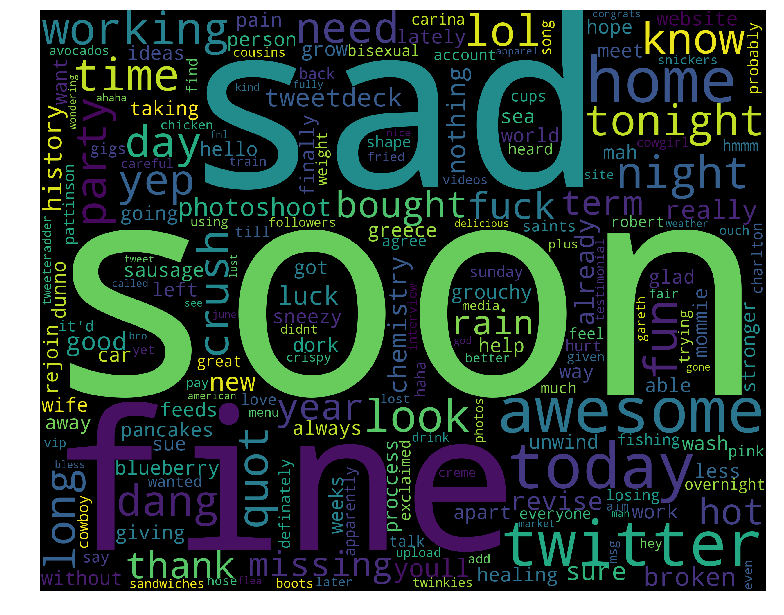

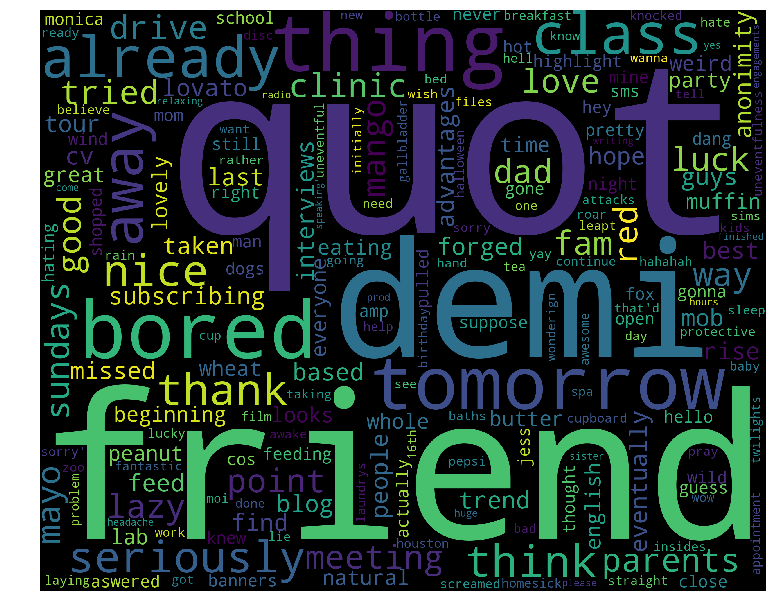

In [31]:
def clean_tweets(train):
    tweets = []
    stopwords_set = set(stopwords.words("english"))

    for row in train.itertuples():
        words_filtered = [e.lower() for e in row.text if len(e) >= 3]
        words_cleaned = [word for word in words_filtered
            if 'http' not in word
            and '://' not in word
            and not word.startswith('@')
            and not word.startswith('#')
            and word not in stopwords_set
            and word != 'RT']
        tweets.append((words_cleaned, row.sentiment))
    
    return tweets

# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features


# train, test = train_test_split(train_df, test_size=0.1)
# train_ = train.iloc[:100]
# test_ = test.iloc[:50]
# tweets = clean_tweets(train_)
# test_tweets = clean_tweets(test_)
# w_features = get_word_features(get_words_in_tweets(tweets))
# wordcloud_draw(w_features)
# test_w_features = get_word_features(get_words_in_tweets(test_tweets))
# wordcloud_draw(test_w_features)

In [32]:
training_set = nltk.classify.apply_features(extract_features, tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [34]:
test_set = nltk.classify.apply_features(extract_features, test_tweets)
print('accuracy:', nltk.classify.util.accuracy(classifier, test_set))
classifier.show_most_informative_features()

accuracy: 0.44
Most Informative Features
      containts(twitter) = True                1 : 0      =      3.2 : 1.0
          containts(i'm) = True                0 : 1      =      2.8 : 1.0
         containts(hope) = True                1 : 0      =      2.5 : 1.0
         containts(love) = True                1 : 0      =      2.5 : 1.0
         containts(good) = True                1 : 0      =      2.5 : 1.0
         containts(time) = True                1 : 0      =      1.8 : 1.0
          containts(sun) = True                1 : 0      =      1.8 : 1.0
        containts(think) = True                1 : 0      =      1.8 : 1.0
      containts(finally) = True                0 : 1      =      1.5 : 1.0
         containts(even) = True                0 : 1      =      1.5 : 1.0


In [35]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))    

AttributeError: 'list' object has no attribute 'split'

In [47]:
import collections, itertools
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews, stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist

def evaluate_classifier(featx):
    negids = movie_reviews.fileids('neg')
    posids = movie_reviews.fileids('pos')
    
    negfeats = [(featx(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
    posfeats = [(featx(movie_reviews.words(fileids=[f])), 'pos') for f in posids]
    
    negcutoff = len(negfeats)*3//4
    poscutoff = len(posfeats)*3//4
    
    trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]
    testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]
    
    classifier = NaiveBayesClassifier.train(trainfeats)
    refsets = collections.defaultdict(set)
    testsets = collections.defaultdict(set)
    
    for i, (feats, label) in enumerate(testfeats):
            refsets[label].add(i)
            observed = classifier.classify(feats)
            testsets[observed].add(i)
    
    print('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
    print('pos precision:', precision(refsets['pos'], testsets['pos']))
    print('pos recall:', recall(refsets['pos'], testsets['pos']))
    print('neg precision:', precision(refsets['neg'], testsets['neg']))
    print('neg recall:', recall(refsets['neg'], testsets['neg']))
    
    classifier.show_most_informative_features()

def word_feats(words):
    return dict([(word, True) for word in words])

# print('evaluating single word features')
# evaluate_classifier(word_feats)

# word_fd = FreqDist()
# label_word_fd = ConditionalFreqDist()

# for word in movie_reviews.words(categories=['pos']):
#     word_fd.update(word.lower())
#     label_word_fd['pos'].update(word.lower())

# for word in movie_reviews.words(categories=['neg']):
#     word_fd.update(word.lower())
#     label_word_fd['neg'].update(word.lower())

# n_ii = label_word_fd[label][word]
# n_ix = word_fd[word]
# n_xi = label_word_fd[label].N()
# n_xx = label_word_fd.N()

pos_word_count = label_word_fd['pos'].N()
neg_word_count = label_word_fd['neg'].N()
total_word_count = pos_word_count + neg_word_count

word_scores = {}

for word, freq in word_fd.items():
    pos_score = BigramAssocMeasures.chi_sq(label_word_fd['pos'][word],
        (freq, pos_word_count), total_word_count)
    neg_score = BigramAssocMeasures.chi_sq(label_word_fd['neg'][word],
        (freq, neg_word_count), total_word_count)
    word_scores[word] = pos_score + neg_score

best = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:10000]
bestwords = set([w for w, s in best])

def best_word_feats(words):
    return dict([(word, True) for word in words if word in bestwords])

print('evaluating best word features')
evaluate_classifier(best_word_feats)

def best_bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    d = dict([(bigram, True) for bigram in bigrams])
    d.update(best_word_feats(words))
    return d

print('evaluating best words + bigram chi_sq word features')
evaluate_classifier(best_bigram_word_feats)

evaluating best word features
accuracy: 0.54
pos precision: 0.7
pos recall: 0.14
neg precision: 0.5222222222222223
neg recall: 0.94
Most Informative Features
                       \ = True              pos : neg    =      2.3 : 1.0
                       % = True              neg : pos    =      2.3 : 1.0
                       8 = True              pos : neg    =      2.1 : 1.0
                       b = True              neg : pos    =      2.0 : 1.0
                       z = True              neg : pos    =      1.9 : 1.0
                       k = True              neg : pos    =      1.8 : 1.0
                       h = True              pos : neg    =      1.8 : 1.0
                       = = True              neg : pos    =      1.7 : 1.0
                       7 = True              pos : neg    =      1.7 : 1.0
                       _ = True              neg : pos    =      1.7 : 1.0
evaluating best words + bigram chi_sq word features
accuracy: 0.816
pos precision: 0.8872549